第6回 転移学習

今回は，転移学習を用いた，超高精度な画像分類を行ってみましょう．

１，転移学習って?

転移学習とは，あらかじめ学習を行ったモデルを使って，別のデータを学習することです．

イメージとしては，ギリシャ数字I~Xの手書き文字を認識するモデルを作る場合，0から自分達でモデルを作るのではなく，0~9までの手書き文字を認識する学習済みモデルを利用して，学習を行うみたいな感じです．

転移学習を行うことにより，モデルを自作するよりも，少ない画像の枚数で高精度な推論を行うことができます．

転移学習の実装方法は意外と簡単かつ大胆です．学習済みモデルの出力を削除して，新しく出力層を追加するという事を行います．以下のリンクにその様子を示します．

<img src="https://aismiley.co.jp/wp-content/uploads/2022/02/transfer-learning-1024x576-1-980x551.png">

2，resnet18を用いた転移学習

早速転移学習を行ってみましょう．今回は，データセットをpytorch公式から持ってくることなく，自前のデータセットを利用してみましょう（詳しい説明などは3回目講習を参照）．3回目の講習で作ったimagesフォルダを，このipynbファイルと同じフォルダ内に入れて下さい．

まずは，ライブラリのインポートや，画像の変換処理などを行っていきます．以下のコードを実行してください．

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#pandasはデータの読み込みや保存に使うやつ
import pandas as pd
#torchvisionのtransformsは、画像データをtensor型にするための処理をまとめたもの
from torchvision import transforms
import torchvision
from PIL import Image

image_size=120

mean = (0.5, 0.5, 0.5) #正規化のパラメータ
std = (0.5, 0.5, 0.5) #同様に正規化のパラメータ

data_transform = {
    #訓練用データセットに対する変換処理
    'train': transforms.Compose([
        transforms.RandomResizedCrop( #画像サイズを指定して，ズームアップとか
            image_size, scale=(0.5, 1.0)
        ),
        transforms.RandomHorizontalFlip(), #左右反転
        transforms.RandomRotation(degrees=[-20, 20]), #回転±20°
        transforms.ToTensor(),
        transforms.Normalize(mean, std), #正規化
        transforms.RandomErasing(0.5), #虫食い
    ]),
    #検証用データセットに対する変換処理
    'test': transforms.Compose([
        transforms.Resize(image_size), #画像サイズ変更
        transforms.CenterCrop(image_size), 
        transforms.ToTensor(),
        transforms.Normalize(mean, std) #正規化
    ])
}

続いて，データセットとデータローダーの制作に入ります．

In [5]:
#データセットの制作
train_dataset = torchvision.datasets.ImageFolder(
    root="images/train",  #訓練用データが入ってるパス
    transform=data_transform["train"] #変換処理
)

test_dataset = torchvision.datasets.ImageFolder(
    root="images/test",  #検証用データのパス
    transform=data_transform["test"]
)

#データローダーの制作
train_dataloader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=30,
    shuffle=True
)

test_dataloader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=30,
    shuffle=True
)

ついでに中身を確認しておきましょう．

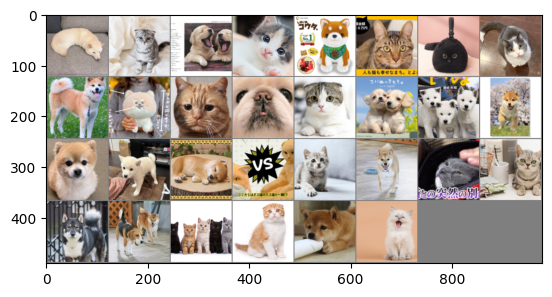

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 #正規化の無効化
    npimg = img.numpy() #表示のためにnumpyへ変換
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

data=iter(test_dataloader)
images, labels = next(data)
images=torchvision.utils.make_grid(images)
imshow(images)

次はpytorch公式から学習済みモデルをダウンロードしてきましょう．今回は軽量なresnet18を使って，転移学習を行います．

In [8]:
from torchvision import models #学習済みモデルを呼び出すためのもの
model = models.resnet18(pretrained=True) #ここで呼び出し
print(model)

c:\Users\user\venv\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\venv\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

resnet18はデフォルトでは1000クラスの分類が可能なモデルであり，これは上の出力の「out_features」をみればわかります．今回はこのresnet18の最終出力である（fc）を別の層に置き換えることで，転移学習が可能なモデルに変化させます．以下はそのコードです．

In [10]:
from torch import nn
num_ftrs = model.fc.in_features #モデルの最終層の入力サイズ取得
model.fc = nn.Linear(num_ftrs, 2) #入力そのまま，出力を2まで減らす．
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

出力が2まで減少して，犬と猫の分類が可能なモデルになりました．

resnet18には，nn.BatchNorm2dと定義される層があります．これはバッチ正規化という処理を行う層で，推論の高速化と高精度化につながる便利な層です．

バッチ正規化とは何ぞや：https://data-analytics.fun/2021/09/11/understanding-batch-normalization/

モデルの構築が完了したので損失関数と，オプティマイザを定義します．

In [13]:
from torch import optim

loss_fn = nn.CrossEntropyLoss() #クロスエントロピー誤差

optimizer = optim.Adam(model.parameters(), lr=0.001) #Adamを使用

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) #10回の学習ごとに，学習率を0.5倍する

では，いよいよ学習に入ります．今回はトレーニング兼検証関数を定義して学習していきます．

In [15]:
dataLoaders={"train":train_dataloader,"val":test_dataloader} #データローダーを格納するディクショナリ
dataset_size={"train":len(train_dataset),"val":len(test_dataset)} #データセットに含まれる画像の枚数を格納するディクショナリ

def train_model(model, loss_fn, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs): #epochの数だけループを繰り返す
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # trainフェーズと，valフェーズ，つまり，トレーニングと検証フェーズごとにfor文を実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # トレーニングフェーズなら，モデルを訓練可能状態に
            else:
                model.eval()   #検証フェーズなら，モデルを検証モードに

            running_loss = 0.0
            running_corrects = 0

            
            #trainなら訓練データローダーを呼び出し
            #valなら検証データローダーを呼び出し
            for inputs, labels in dataLoaders[phase]:
                #傾きをゼロにリセット
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs) #推論

                    #torch.maxはtensor配列の最大値と，最大値のインデックスを返す
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    #トレーニングフェーズなら誤差逆伝播を行う
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失と正解回数の合計を計算
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 損失と正解回数の平均算出
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 最大精度が出ると，その値を保存
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
        print()
        
    print('Best val Acc: {:4f}'.format(best_acc))

    # モデルを返す
    return model

定義が終了したので学習開始です．今回は24回の学習ループを行います．

In [16]:
model_ft = train_model(model, loss_fn, optimizer, exp_lr_scheduler,num_epochs=24)

Epoch 0/23
----------


c:\Users\user\venv\torch\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6993 Acc: 0.5900
val Loss: 2.2131 Acc: 0.6600

Epoch 1/23
----------
train Loss: 0.5477 Acc: 0.8100
val Loss: 18.9507 Acc: 0.6200

Epoch 2/23
----------
train Loss: 0.9376 Acc: 0.7800
val Loss: 3.2696 Acc: 0.8100

Epoch 3/23
----------
train Loss: 0.5831 Acc: 0.8200
val Loss: 1.9840 Acc: 0.8300

Epoch 4/23
----------
train Loss: 0.2940 Acc: 0.8400
val Loss: 0.6700 Acc: 0.8500

Epoch 5/23
----------
train Loss: 0.6565 Acc: 0.8300
val Loss: 0.1844 Acc: 0.9300

Epoch 6/23
----------
train Loss: 0.2591 Acc: 0.9000
val Loss: 0.1003 Acc: 0.9500

Epoch 7/23
----------
train Loss: 0.2552 Acc: 0.9100
val Loss: 0.0686 Acc: 0.9600

Epoch 8/23
----------
train Loss: 0.3363 Acc: 0.8600
val Loss: 0.0835 Acc: 0.9600

Epoch 9/23
----------
train Loss: 0.2243 Acc: 0.8700
val Loss: 0.0810 Acc: 0.9600

Epoch 10/23
----------
train Loss: 0.3447 Acc: 0.9000
val Loss: 0.0791 Acc: 0.9600

Epoch 11/23
----------
train Loss: 0.2874 Acc: 0.8800
val Loss: 0.0770 Acc: 0.9600

Epoch 12/23
----------


恐らくAcc（正確性）が90%後半くらいまで跳ね上がっているのではないのでしょうか？これが転移学習の恐ろしさです．

では念のため，精度を検証してみましょう！！

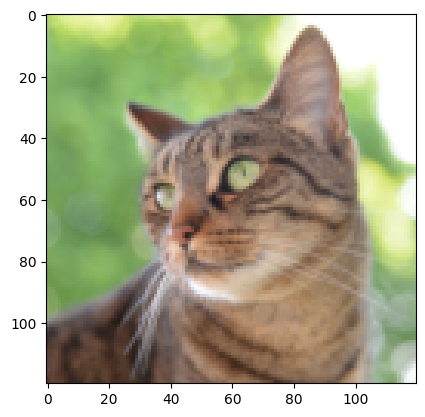

pred:猫,label:猫


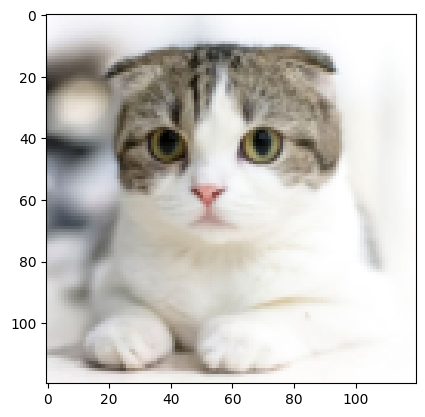

pred:猫,label:猫


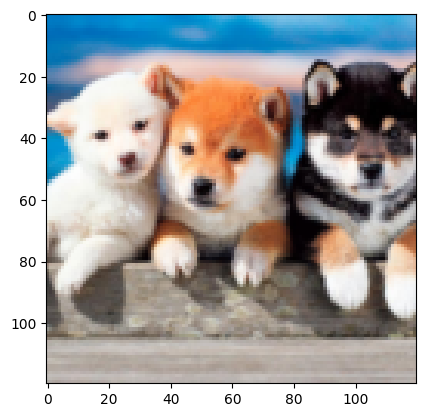

pred:犬,label:犬


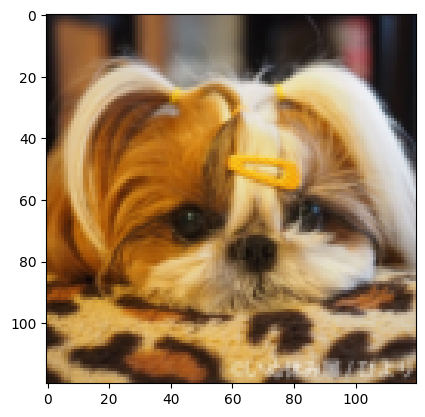

pred:犬,label:犬


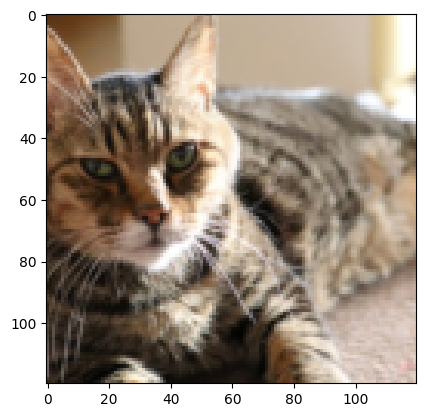

pred:猫,label:猫


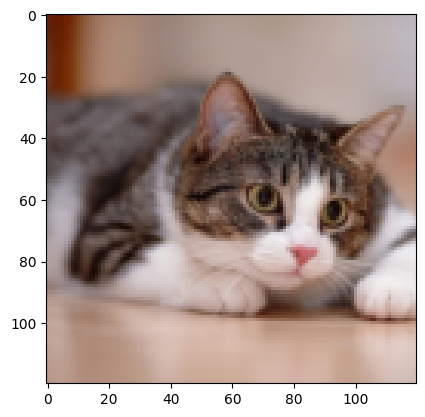

pred:猫,label:猫


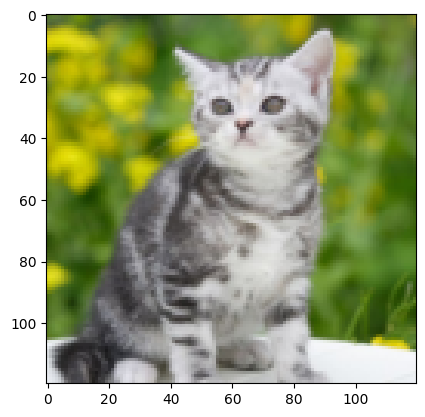

pred:猫,label:猫


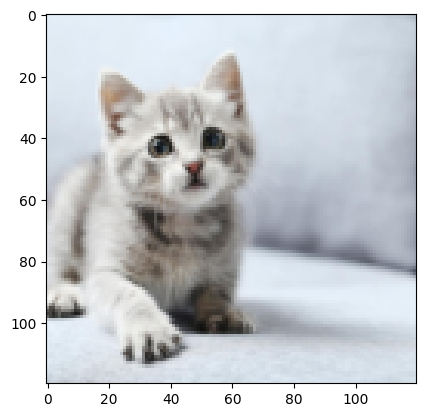

pred:猫,label:猫


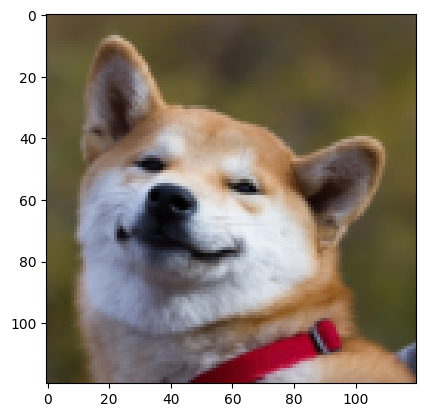

pred:犬,label:犬


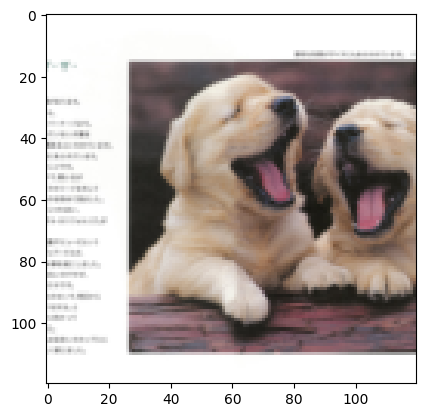

pred:犬,label:犬


In [18]:
classes={0:"猫",1:"犬"}

def imshow(img):
    img = img / 2 + 0.5 #正規化の無効化
    npimg = img.numpy() #表示のためにnumpyへ変換
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

def val_model(model_ft,pred_num=4):
    count=0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataLoaders['val']):
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(pred_num):
                imshow(inputs[j])
                print(f"pred:{classes[preds[j].item()]},label:{classes[labels[j].item()]}")
                if j>=pred_num:
                    break
            break

val_model(model_ft,10)

今回の場合，ほぼ100%の確率で認識できていると思います。

実際の画像分類では，自分でCNNを構築する機会は少なく転移学習を行うことがほとんどです．とても重要な項目なのでコードの雛形としてちょくちょく参考にしてください

また，今回はresnet18というモデルを使いましたがVGG16やImageNetと呼ばれるモデルがPytorchには数多く用意されています．興味がある方はそちらもぜひ試してみてください．今回の講習は以上です。お疲れ様でした。